In [35]:
from skimage.morphology import thin
import numpy as np

def plot_segmentation_boundaries(image_np, output_mask, figsize=(15, 15)):
    """
    Plot the boundaries of the segmentation over the original image.
    Uses pixel comparison to detect boundaries and applies thinning.
    """
    output_mask_np = output_mask

    # Find boundaries by comparing neighboring pixels
    boundaries = np.zeros_like(output_mask_np)
    boundaries[1:, :] = np.logical_or(boundaries[1:, :], output_mask_np[1:, :] != output_mask_np[:-1, :])  # Compare vertically
    boundaries[:, 1:] = np.logical_or(boundaries[:, 1:], output_mask_np[:, 1:] != output_mask_np[:, :-1])  # Compare horizontally

    # Apply thinning to ensure boundaries are only 1 pixel wide
    boundaries = thin(boundaries)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.imshow(image_np)

    ax.contour(boundaries, colors='red', linewidths=0.7)

    ax.set_title('Image with Segmentation Boundaries (Thinned)')
    ax.axis('off')

    plt.show()

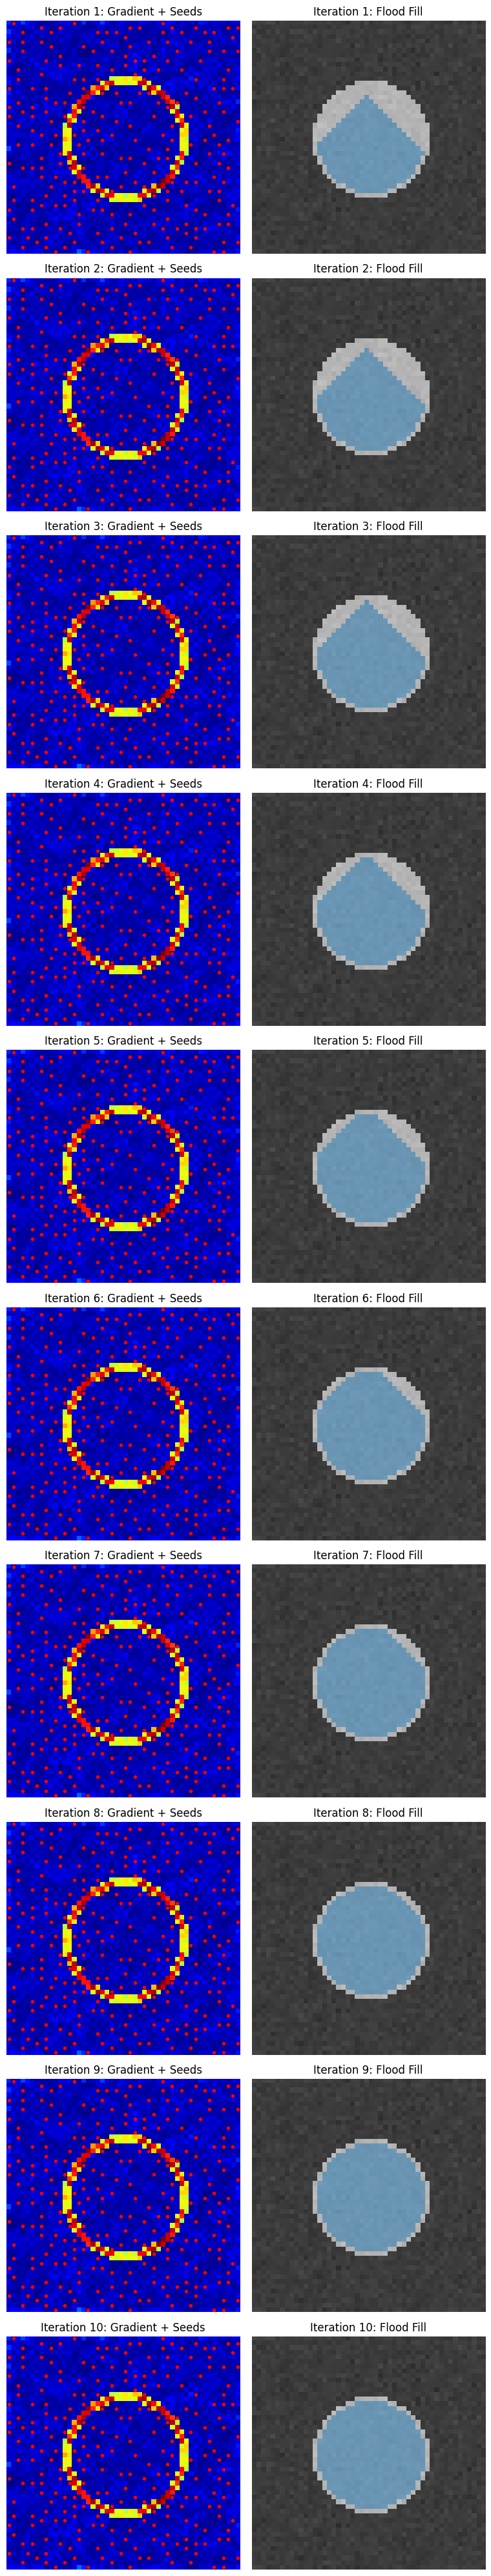

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from math import sqrt

# -----------------------
# 1. Create a Synthetic Image (Circle + Noise)
# -----------------------
np.random.seed(0)
H, W = 50, 50
image = np.zeros((H, W), dtype=np.float32)

center = (H // 2, W // 2)
radius = min(H, W) / 4

for r in range(H):
    for c in range(W):
        dist = sqrt((r - center[0])**2 + (c - center[1])**2)
        if dist < radius:
            image[r, c] = 180  # Brighter circle interior
        else:
            image[r, c] = 60   # Darker exterior

# Add moderate noise
image += np.random.normal(scale=5, size=image.shape)
image = np.clip(image, 0, 255)

# -----------------------
# 2. Compute Gradient Magnitude
# -----------------------
gy, gx = np.gradient(image)
grad_mag = np.sqrt(gx**2 + gy**2)

# -----------------------
# 3. Find Local Minima as Possible Seeds
# -----------------------
local_min_coords = []
for r in range(H):
    for c in range(W):
        rmin = max(r - 1, 0)
        rmax = min(r + 2, H)
        cmin = max(c - 1, 0)
        cmax = min(c + 2, W)
        patch = grad_mag[rmin:rmax, cmin:cmax]
        if grad_mag[r, c] <= patch.min():
            local_min_coords.append((r, c))

local_min_coords = set(local_min_coords)

# We'll just pick ONE seed (the first in ascending grad_mag order)
# This is for demonstration of iterative BFS expansion
sorted_seeds = sorted(local_min_coords, key=lambda idx: grad_mag[idx])
if len(sorted_seeds) == 0:
    raise ValueError("No local minima found!")
seed = sorted_seeds[0]

# -----------------------
# 4. BFS from that single seed, capturing iteration snapshots
# -----------------------
labels = np.zeros_like(image, dtype=int)

edge_threshold = 20
current_label = 1  # We'll use label=1 for this single seed

# Initialize BFS
labels[seed] = current_label
queue = deque([seed])

snapshots = []   # will store (labels_snapshot) after each BFS iteration
iterations = 0   # BFS iteration counter

while queue:
    iterations += 1
    
    # Process one "level" of BFS
    level_size = len(queue)
    for _ in range(level_size):
        r, c = queue.popleft()
        
        # Check 4-neighbors
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < H and 0 <= nc < W:
                if labels[nr, nc] == 0:  # not labeled yet
                    if grad_mag[nr, nc] < edge_threshold:
                        labels[nr, nc] = current_label
                        queue.append((nr, nc))
    
    # After finishing one BFS "level," store a snapshot
    snapshots.append(labels.copy())

# -----------------------
# 5. Visualization of Each BFS Iteration
# -----------------------
# We'll show a row of subplots for each BFS iteration.
# For each iteration, we show:
#  - (left) gradient map + *all* seeds in red
#  - (right) alpha-blended labels over the original image
#
# Because BFS can have many iterations, this might produce MANY plots.
# For demonstration, let's limit to the final 10 iterations if we have more than 10.

max_plots = 10
if iterations > max_plots:
    # Show only the last 10 iterations
    snapshots = snapshots[-max_plots:]
    iterations = max_plots

fig, axes = plt.subplots(iterations, 2, figsize=(8, 4*iterations), dpi=100)

# If there's only 1 iteration, axes is not a 2D array, so let's handle that
if iterations == 1:
    axes = np.array([axes])  # wrap in an array to treat consistently

# For convenience, let's create a list of *all* seeds as an array 
# so we can plot them easily in each iteration.
all_seeds_array = np.array(list(local_min_coords))

for i, snap in enumerate(snapshots):
    # Left subplot: gradient + seeds
    ax_left = axes[i, 0]
    ax_left.imshow(grad_mag, cmap='jet')
    ax_left.plot(all_seeds_array[:,1], all_seeds_array[:,0], 'ro', markersize=3)
    ax_left.set_title(f"Iteration {i+1}: Gradient + Seeds")
    ax_left.axis('off')
    
    # Right subplot: alpha-blended labels over original image
    ax_right = axes[i, 1]
    ax_right.imshow(image, cmap='gray', vmin=0, vmax=255)
    masked_labels = np.ma.masked_where(snap == 0, snap)
    ax_right.imshow(masked_labels, cmap='tab20', alpha=0.5, interpolation='nearest')
    ax_right.set_title(f"Iteration {i+1}: Flood Fill")
    ax_right.axis('off')

plt.tight_layout()
plt.show()


In [7]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# ------------------------------------------------

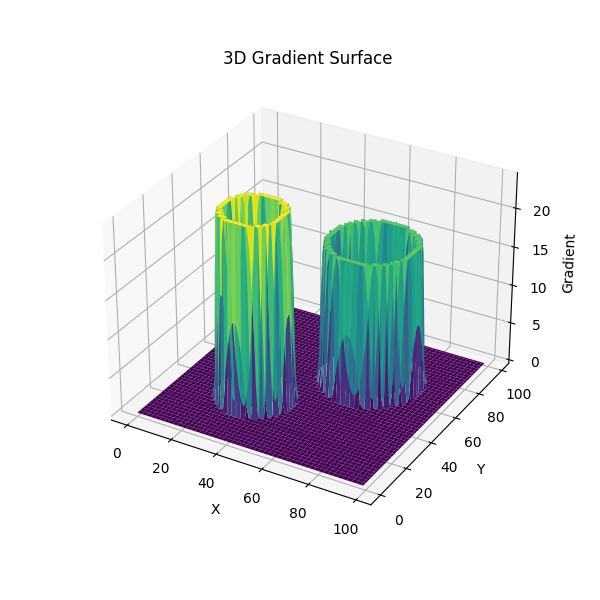

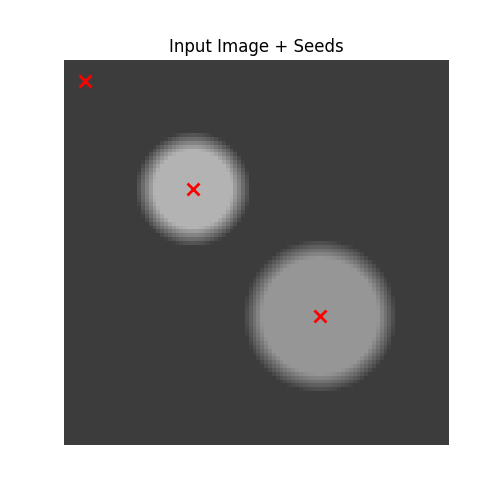

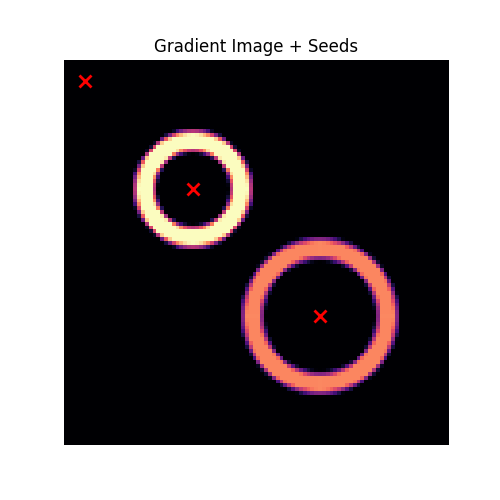

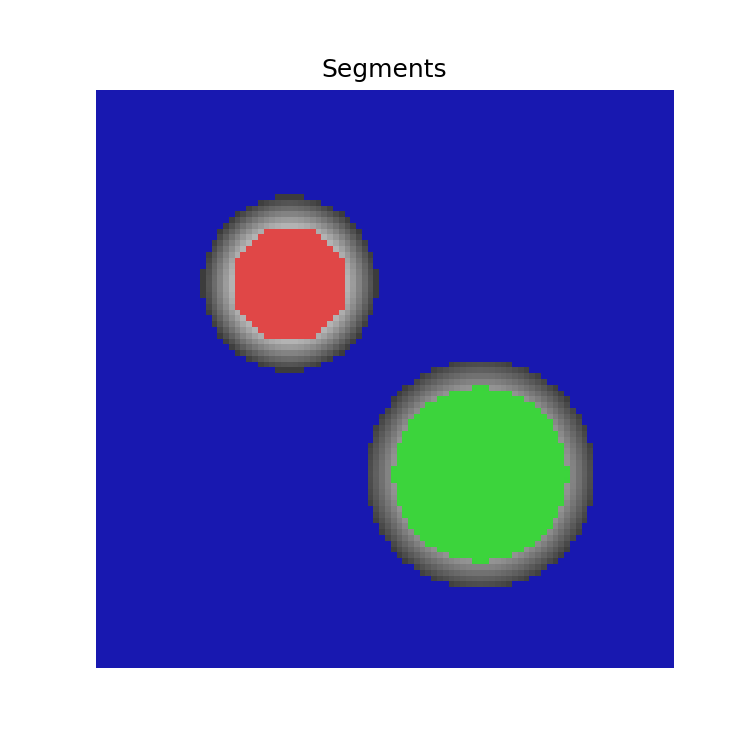

In [9]:
np.random.seed(0)

H, W = 100, 100
image = np.zeros((H, W), dtype=np.float32)

bg_intensity = 60
circle1_intensity = 180
circle2_intensity = 150
fade_width = 5.0

center1 = (H // 3, W // 3)         
radius1 = 15

center2 = (2*H // 3, 2*W // 3)
radius2 = 20

for r in range(H):
    for c in range(W):
        dist1 = sqrt((r - center1[0])**2 + (c - center1[1])**2)
        dist2 = sqrt((r - center2[0])**2 + (c - center2[1])**2)
        
        val = bg_intensity
        
        # Circle 1 fade
        if dist1 < (radius1 - fade_width):
            val = max(val, circle1_intensity)
        elif dist1 < radius1:
            fade_frac = (radius1 - dist1) / fade_width
            blended_val = bg_intensity + fade_frac*(circle1_intensity - bg_intensity)
            val = max(val, blended_val)
        
        # Circle 2 fade
        if dist2 < (radius2 - fade_width):
            val = max(val, circle2_intensity, val)
        elif dist2 < radius2:
            fade_frac = (radius2 - dist2) / fade_width
            blended_val = bg_intensity + fade_frac*(circle2_intensity - bg_intensity)
            val = max(val, blended_val)

        image[r, c] = val

image = np.clip(image, 0, 255)

# 2. Gradient Magnitude
gy, gx = np.gradient(image)
grad_mag = np.sqrt(gx**2 + gy**2)

# 3. Place Three Seeds
seed1 = (center1[0], center1[1])  # circle #1 center
seed2 = (center2[0], center2[1])  # circle #2 center
seed3 = (5, 5)                    # top-left corner for background

seeds = [seed1, seed2, seed3]

# 4. Multi-Seed BFS with NO Overwriting
labels = np.zeros_like(image, dtype=int)
edge_threshold = 10  # BFS won't cross circle boundaries easily

from collections import deque
for label_idx, (r, c) in enumerate(seeds, start=1):
    if labels[r, c] == 0:
        labels[r, c] = label_idx
        queue = deque([(r, c)])
        
        while queue:
            rr, cc = queue.popleft()
            for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                nr, nc = rr + dr, cc + dc
                if 0 <= nr < H and 0 <= nc < W:
                    if labels[nr, nc] == 0 and grad_mag[nr, nc] < edge_threshold:
                        labels[nr, nc] = label_idx
                        queue.append((nr, nc))

# 5. Visualization in Separate Figures
# (A) Original + Seeds
figA = plt.figure(figsize=(5,5))
axA = figA.add_subplot(111)
axA.imshow(image, cmap='gray', vmin=0, vmax=255)
for (rr, cc) in seeds:
    axA.plot(cc, rr, 'rx', markersize=8, mew=2)
axA.set_title("Input Image + Seeds")
axA.axis('off')

# (B) Gradient + Seeds

figB = plt.figure(figsize=(5,5))
axB = figB.add_subplot(111)
axB.imshow(grad_mag, cmap='magma')  
for (rr, cc) in seeds:
    axB.plot(cc, rr, 'rx', markersize=8, mew=2)
axB.set_title("Gradient Image + Seeds")
axB.axis('off')

masked_labels = np.ma.masked_where(labels == 0, labels - 1)
cmap = mcolors.ListedColormap([(1,0,0), (0,1,0), (0,0,1)])

figC = plt.figure(figsize=(5,5), dpi=150)
axC = figC.add_subplot(111)
axC.imshow(image, cmap='gray', vmin=0, vmax=255)
axC.imshow(masked_labels, cmap=cmap, alpha=0.6,
           interpolation='nearest', vmin=0, vmax=2)
axC.set_title("Segments")
axC.axis('off')

# (D) 3D Gradient Surface
figD = plt.figure(figsize=(6,6))
axD = figD.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(W), np.arange(H))
surf = axD.plot_surface(X, Y, grad_mag, cmap='viridis', edgecolor='none')
axD.set_xlabel("X")
axD.set_ylabel("Y")
axD.set_zlabel("Gradient")
axD.set_title("3D Gradient Surface")

plt.show()


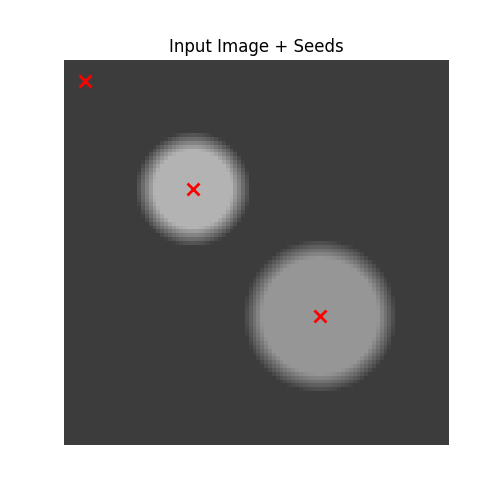

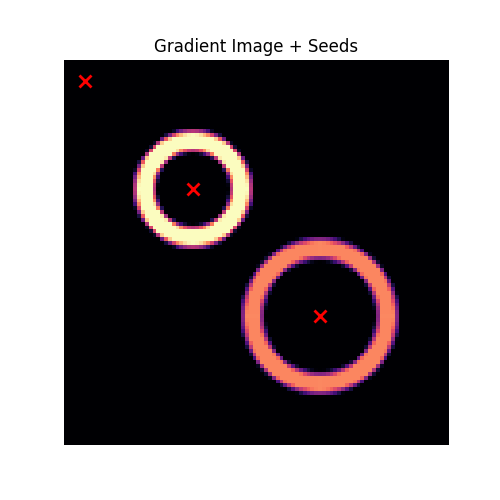

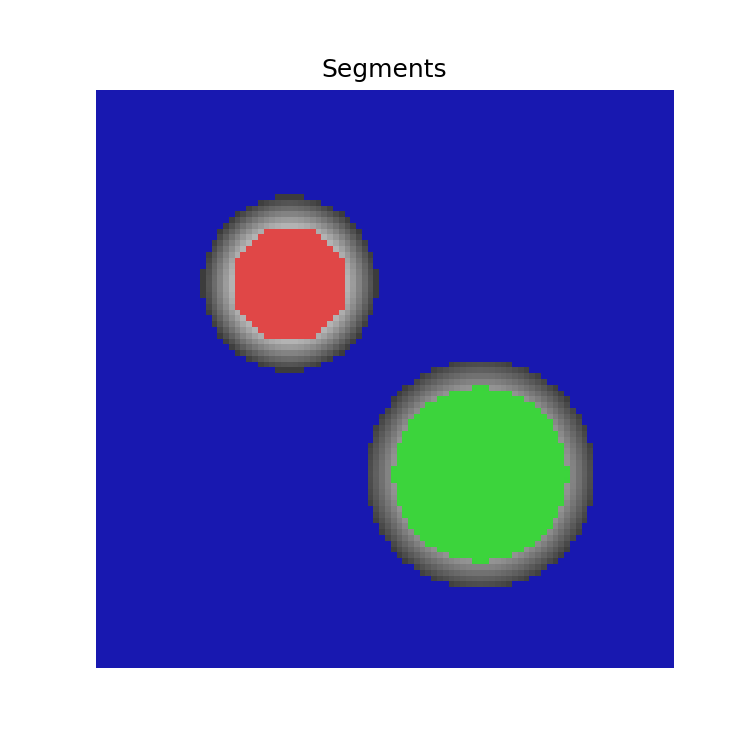

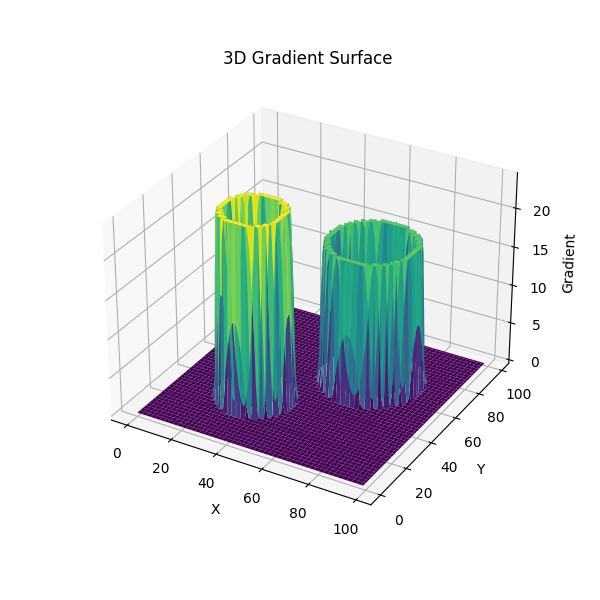

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from math import sqrt
from collections import deque

# 1. Generate Image with Two Faded Circles
np.random.seed(0)

H, W = 100, 100
image = np.zeros((H, W), dtype=np.float32)

bg_intensity = 60
circle1_intensity = 180
circle2_intensity = 150
fade_width = 5.0

center1 = (H // 3, W // 3)
radius1 = 15

center2 = (2*H // 3, 2*W // 3)
radius2 = 20

for r in range(H):
    for c in range(W):
        dist1 = sqrt((r - center1[0])**2 + (c - center1[1])**2)
        dist2 = sqrt((r - center2[0])**2 + (c - center2[1])**2)
        
        val = bg_intensity
        
        # Circle 1 fade
        if dist1 < (radius1 - fade_width):
            val = max(val, circle1_intensity)
        elif dist1 < radius1:
            fade_frac = (radius1 - dist1) / fade_width
            blended_val = bg_intensity + fade_frac*(circle1_intensity - bg_intensity)
            val = max(val, blended_val)
        
        # Circle 2 fade
        if dist2 < (radius2 - fade_width):
            val = max(val, circle2_intensity, val)
        elif dist2 < radius2:
            fade_frac = (radius2 - dist2) / fade_width
            blended_val = bg_intensity + fade_frac*(circle2_intensity - bg_intensity)
            val = max(val, blended_val)

        image[r, c] = val

image = np.clip(image, 0, 255)

# 2. Gradient Magnitude
gy, gx = np.gradient(image)
grad_mag = np.sqrt(gx**2 + gy**2)

# 3. Place Three Seeds
seed1 = (center1[0], center1[1])  # circle #1 center
seed2 = (center2[0], center2[1])  # circle #2 center
seed3 = (5, 5)                    # top-left corner for background

seeds = [seed1, seed2, seed3]

# 4. Multi-Seed BFS with NO Overwriting
labels = np.zeros_like(image, dtype=int)
edge_threshold = 10  # BFS won't cross circle boundaries easily

for label_idx, (r, c) in enumerate(seeds, start=1):
    if labels[r, c] == 0:
        labels[r, c] = label_idx
        queue = deque([(r, c)])
        
        while queue:
            rr, cc = queue.popleft()
            for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                nr, nc = rr + dr, cc + dc
                if 0 <= nr < H and 0 <= nc < W:
                    if labels[nr, nc] == 0 and grad_mag[nr, nc] < edge_threshold:
                        labels[nr, nc] = label_idx
                        queue.append((nr, nc))

# 5A. Visualization - Original Image + Seeds
figA = plt.figure(figsize=(5,5))
axA = figA.add_subplot(111)
axA.imshow(image, cmap='gray', vmin=0, vmax=255)
for (rr, cc) in seeds:
    axA.plot(cc, rr, 'rx', markersize=8, mew=2)
axA.set_title("Input Image + Seeds")
axA.axis('off')
plt.show()   # Show Figure A, then wait for it to close

# 5B. Visualization - Gradient Image + Seeds
figB = plt.figure(figsize=(5,5))
axB = figB.add_subplot(111)
axB.imshow(grad_mag, cmap='magma')
for (rr, cc) in seeds:
    axB.plot(cc, rr, 'rx', markersize=8, mew=2)
axB.set_title("Gradient Image + Seeds")
axB.axis('off')
plt.show()   # Show Figure B

# 5C. Visualization - Segments
masked_labels = np.ma.masked_where(labels == 0, labels - 1)
cmap = mcolors.ListedColormap([(1,0,0), (0,1,0), (0,0,1)])

figC = plt.figure(figsize=(5,5), dpi=150)
axC = figC.add_subplot(111)
axC.imshow(image, cmap='gray', vmin=0, vmax=255)
axC.imshow(masked_labels, cmap=cmap, alpha=0.6,
           interpolation='nearest', vmin=0, vmax=2)
axC.set_title("Segments")
axC.axis('off')
plt.show()   # Show Figure C

# 5D. Visualization - 3D Gradient Surface
figD = plt.figure(figsize=(6,6))
axD = figD.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(W), np.arange(H))
surf = axD.plot_surface(X, Y, grad_mag, cmap='viridis', edgecolor='none')
axD.set_xlabel("X")
axD.set_ylabel("Y")
axD.set_zlabel("Gradient")
axD.set_title("3D Gradient Surface")
plt.show()   # Show Figure D
